# Data Analysis

## Setup
### Import libraries

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import wordlemodule
from scipy.stats import pearsonr
import pandas as pd
import seaborn as sns

### Open data from saved file and create a WordleModule object with it
```wordlemodule.py``` defines a custom class to create and perform calculations on Wordle objects. The data is loaded from the pickle file, and a new wordle object called "data" is created.

In [2]:
# Open pickle file
with open('Data/Script data/Imported_email_data_with_ints.pkl','rb') as file:
    full_data = pickle.load(file)

# Create custom wordle object with input data
data = wordlemodule.WordleData(full_data)

## Plots

### Mean solve score

The first value of interest is the mean solve score per person, where solve score is the number of guesses it took until the puzzle was completely solved (all green in one row). For example, if it only took three guesses to fully guess the word, then the solve score is three.

In the left panel, data is shown as a box plot denoting the interquartile range and median in thin black lines, mean as a thick purple dashed line, and outliers as black-rimmed white circle.

In the right panel, the frequency of each solve score is shown in a histogram. The frequency of unsolved puzzles is shown as well.

*Make histogram normalized?

C:\Users\Andrés\AppData\Local\Temp\ipykernel_15860\1686489573.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['','1','2','3','4','5','6','Unsolved'])


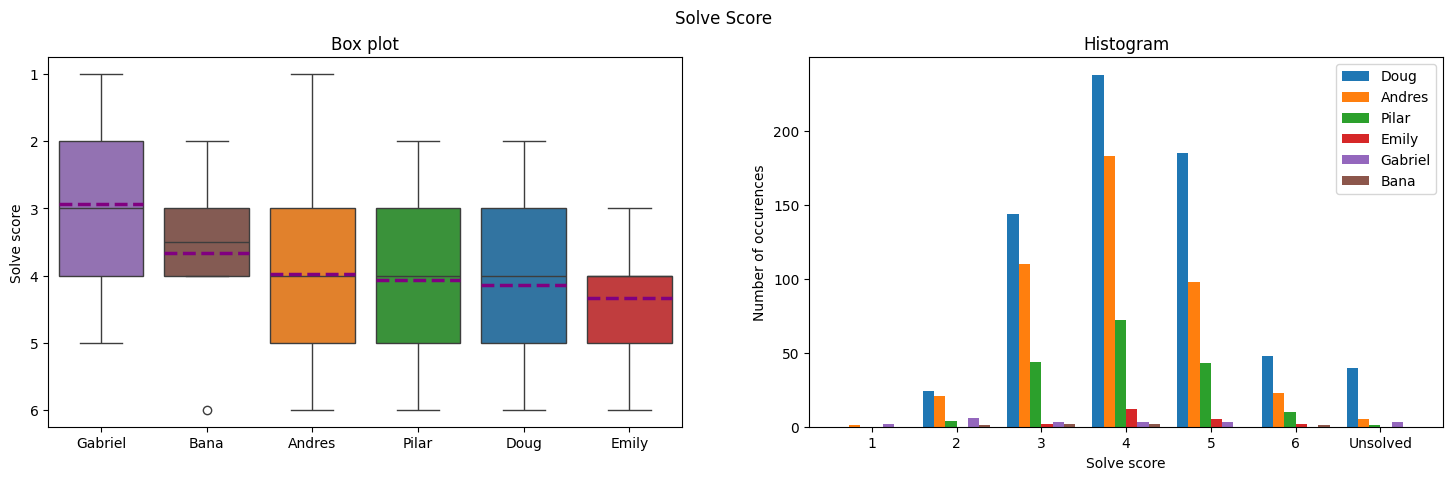

In [3]:
# Create figure with two subplots
f,ax = plt.subplots(1,2)
f.set_figwidth(18)
f.suptitle('Solve Score')

# Subplot 1: Plot mean solve score
df = data.as_df()
df = df.drop('Puzzle Number',axis=1).replace(7,np.nan)
sorted_cols = df.mean().sort_values(ascending=True)
df_sorted = df[sorted_cols.index]

meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
sns.boxplot(data=df_sorted,
               ax=ax[0],
               showmeans = True,
               meanline = True,
               meanprops = meanlineprops,
               legend='auto',
               #whis=2,
               hue_order = df.keys())

ax[0].set(ylabel = 'Solve score',
          title = 'Box plot')
ax[0].invert_yaxis()

# Subplot 2: Plot a histogram of solve score
ax[1].hist(data.data_arr, bins=np.arange(0.5,8.5,1))

ax[1].set_ylabel('Number of occurences')
ax[1].set_xlabel('Solve score')
ax[1].set_xticklabels(['','1','2','3','4','5','6','Unsolved'])
ax[1].set_title('Histogram')
ax[1].legend(data.data_dict.keys())

## General statistics and streaks

Pretty self-explanatory. All the categories are only based on puzzles in the period from the first puzzle to the last puzzle submitted, so for example "puzzles not attempted" only includes puzzles not attempted from puzzle numbers 220-250 if #220 was the first puzzle submitted and #250 was the last.

In [4]:
display(data.stats())

,Mean solve score,Solve score standard deviation,Best solve score,Puzzles attempted,Puzzles not attempted,Longest not attempted puzzle streak,Longest attempted puzzle streak,Mean days between puzzles
Person,,,,,,,,
Doug,4.307806,1.160224,2,679,327,22,55,1.482301
Andres,4.009070,0.997683,1,441,564,28,19,2.281818
Pilar,4.080460,0.933864,2,174,801,135,14,5.630058
Emily,4.333333,0.795822,3,21,140,44,3,8.000000
Gabriel,3.550000,1.932411,1,20,117,61,4,7.157895
Bana,3.666667,1.366260,2,6,200,92,2,41.000000


### Solve score over time

Did people improve their average scores over time?

To answer this question, we first want to inspect how scores change over time. However, the quantized nature of the scores (1, 2 ... 6) makes them hard to interpret in a standard scatter plot or line plot. Therefore, the moving average of scores (aka a sliding window mean) as a function of puzzle number is shown instead. (If there are not sufficient scores to calculate the mean given the window size, a warning is shown and that data is excluded.)

Next, a linear regression model is generated from the solve scores and predicted values are shown in a line graph over the range of puzzles they completed. A negative slope indicates that 

Lastly, a heatmap helps the eye catch 

c:\Users\Andrés\Documents\Visual Studio Code\Wordle Analyzer\wordlemodule.py:173: UserWarning: Gabriel only has 20 values, which is not enough to calculate using a sliding widow size of 20
  warnings.warn(f'{mykey} only has {data_to_roll.size} values, which is not enough to calculate using a sliding widow size of {mywindow}')
c:\Users\Andrés\Documents\Visual Studio Code\Wordle Analyzer\wordlemodule.py:173: UserWarning: Bana only has 6 values, which is not enough to calculate using a sliding widow size of 20
  warnings.warn(f'{mykey} only has {data_to_roll.size} values, which is not enough to calculate using a sliding widow size of {mywindow}')


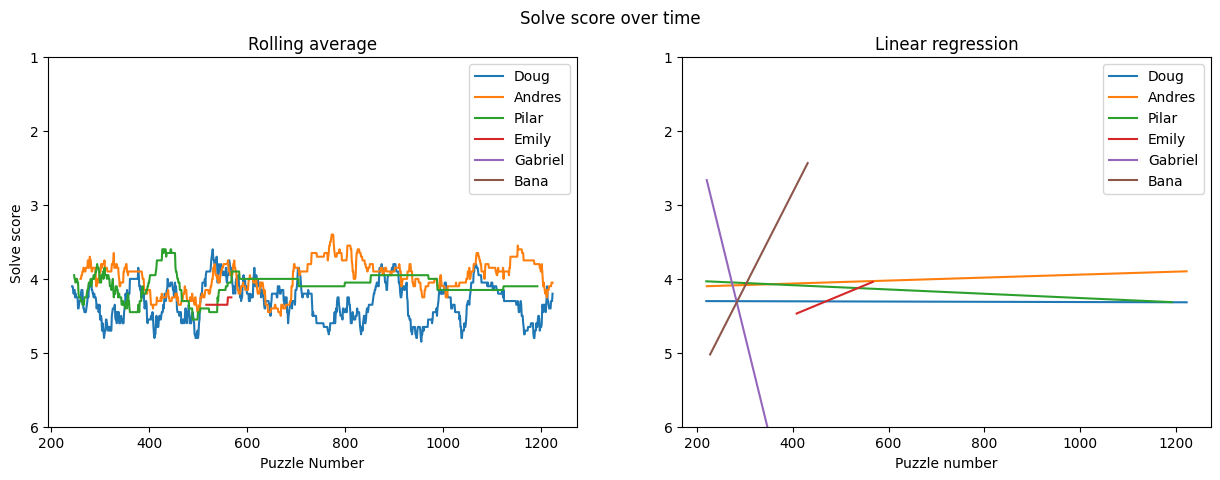

In [20]:
# Set up pandas dataframe with rolling average
df = data.rolling(20)

# Set up figure for plotting
myfig, myax = plt.subplots(1,2)

# Plot scatterplot for solve score over time
df.plot(title="Rolling average",
               subplots=False,
               ax=myax[0], 
               ylim=[6,1], 
               yticks=range(1,7,1),
               xlabel='Puzzle Number',
               ylabel='Solve score',
               )

# Plot linear regression
df_predicted = data.linear_reg()
df_predicted.plot(
    title='Linear regression',
    ax=myax[1],
    ylim=[6,1], 
    xlabel='Puzzle number'
)



# Set figure properties
myfig.suptitle('Solve score over time')
myfig.set_figwidth(15)

### By week-day
Does solve score depened on the day of the week? For example, people may have more time to think about guesses on weekends, and therefore have higher scores on weekends as compared to weekdays.

However, 

(6.0, 1.0)

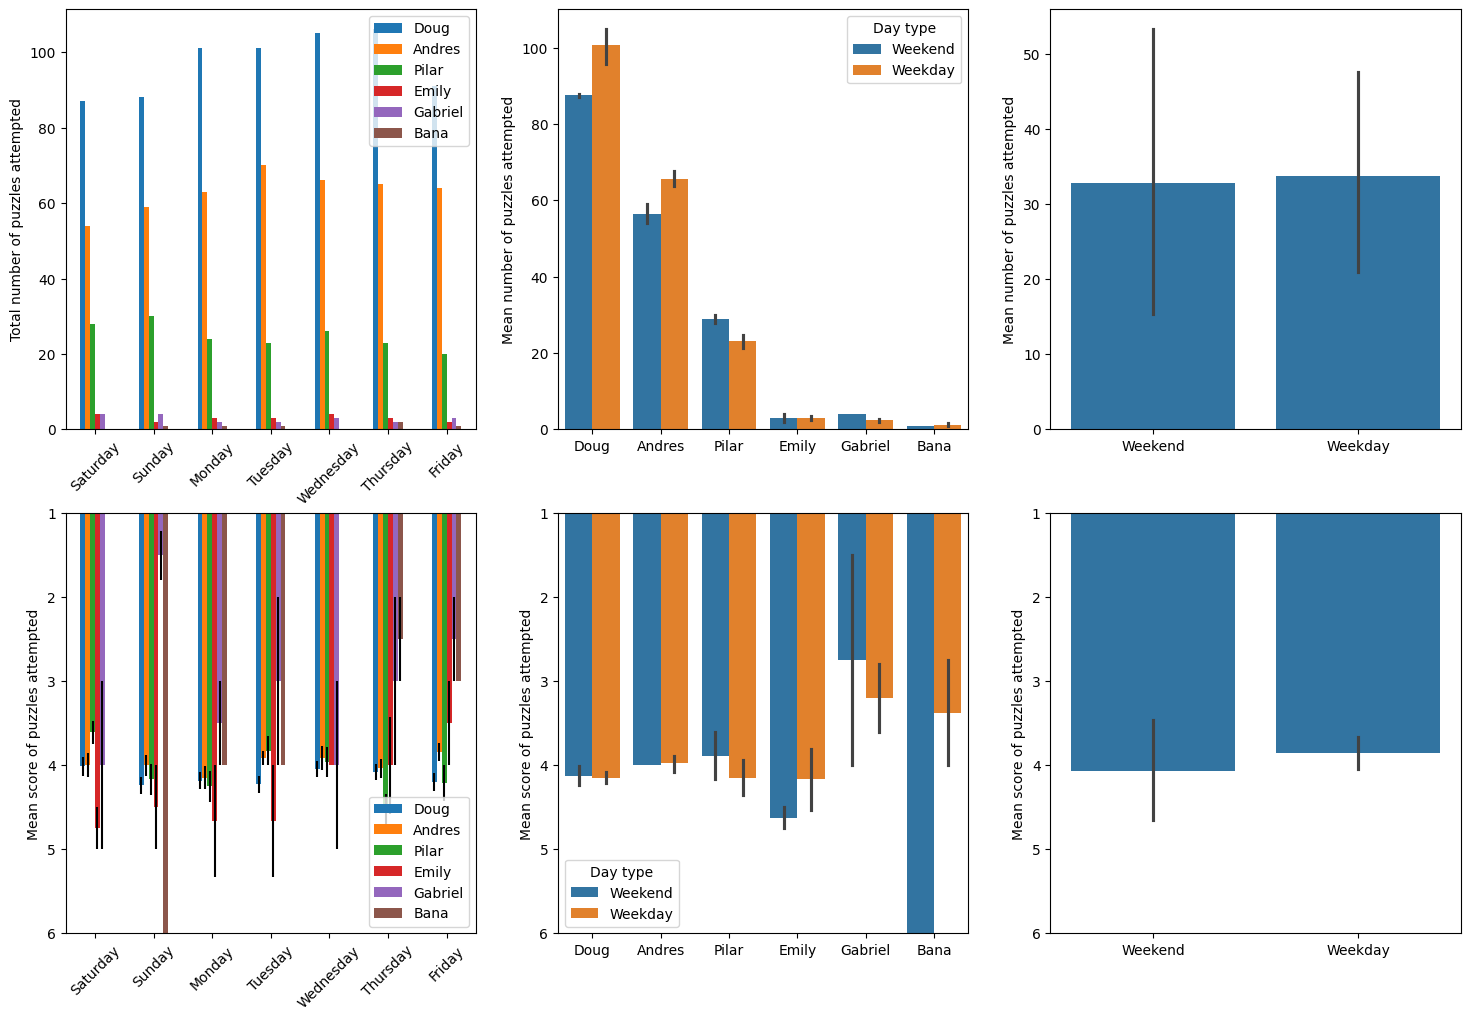

In [8]:
# Use the Wordle object functions to return 
df_weekly_sum, df_weekly_score, df_weekly_score_sem = data.weekly()

# Create figure and axes for subplots
f, myax = plt.subplots(2, 3)
f.set_figwidth(18)
f.set_figheight(12)
#f.suptitle('Number of puzzles attempted by weekday')

# Subplot column 0: number/score of puzzles attempted
df_weekly_sum.plot.bar(ylabel='Total number of puzzles attempted',
                       xlabel='',
                       rot=45,
                       ax=myax[0,0])
#sns.barplot(df_weekly_score)
df_weekly_score.plot.bar(ylabel='Mean score of puzzles attempted',
                       xlabel='',
                       rot=45,
                       ax=myax[1,0],
                       yerr=df_weekly_score_sem)
myax[1,0].set_ylim(6,1)

# Add a weekday and weekend variable and change to long-form data
df_weekly_sum['Day type'] = 'Weekday'
df_weekly_score['Day type'] = 'Weekday'
weekends = ['Sunday','Saturday']

df_weekly_sum.loc[weekends,'Day type'] = 'Weekend'
df_weekly_sum_long = pd.melt(df_weekly_sum, id_vars='Day type', var_name='Person', value_name='Value')


df_weekly_score.loc[weekends,'Day type'] = 'Weekend'
df_weekly_score_long = pd.melt(df_weekly_score, id_vars='Day type', var_name='Person', value_name='Value')

# Subplot column 1: number/score of puzzles attempted, by weekend and weekday and by person
sns.barplot(df_weekly_sum_long,
            x = 'Person',
            y = 'Value',
            hue = 'Day type',
            legend=True,
            ax=myax[0,1])
myax[0,1].set(ylabel = 'Mean number of puzzles attempted',xlabel='')

sns.barplot(df_weekly_score_long,
            x = 'Person',
            y = 'Value',
            hue = 'Day type',
            legend=True,
            ax=myax[1,1])
myax[1,1].set(ylabel = 'Mean score of puzzles attempted',xlabel='')
myax[1,1].set_ylim(6,1)

# Subplot column 2: number/score of puzzles attempted, by weekend and weekday
sns.barplot(data=df_weekly_sum_long,
            x = 'Day type',
            y = 'Value',
            legend=True,
            ax=myax[0,2])
myax[0,2].set(ylabel = 'Mean number of puzzles attempted',xlabel='')

sns.barplot(df_weekly_score_long,
            x = 'Day type',
            y = 'Value',
            legend=True,
            ax=myax[1,2])
myax[1,2].set(ylabel = 'Mean score of puzzles attempted',xlabel='')
myax[1,2].set_ylim(6,1)

### Scatterplot
- compare score of each game - are same words hard for everyone?
Make regressions for each comparison to see who tracks the best

c:\Users\Andrés\Documents\Visual Studio Code\Wordle Analyzer\wordlemodule.py:173: UserWarning: Gabriel only has 20 values, which is not enough to calculate using a sliding widow size of 20
  warnings.warn(f'{mykey} only has {data_to_roll.size} values, which is not enough to calculate using a sliding widow size of {mywindow}')
c:\Users\Andrés\Documents\Visual Studio Code\Wordle Analyzer\wordlemodule.py:173: UserWarning: Bana only has 6 values, which is not enough to calculate using a sliding widow size of 20
  warnings.warn(f'{mykey} only has {data_to_roll.size} values, which is not enough to calculate using a sliding widow size of {mywindow}')


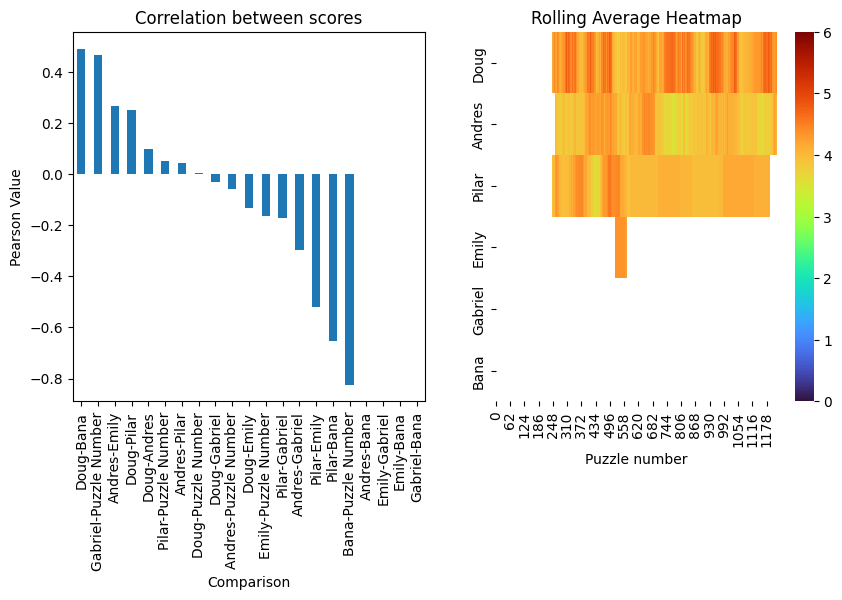

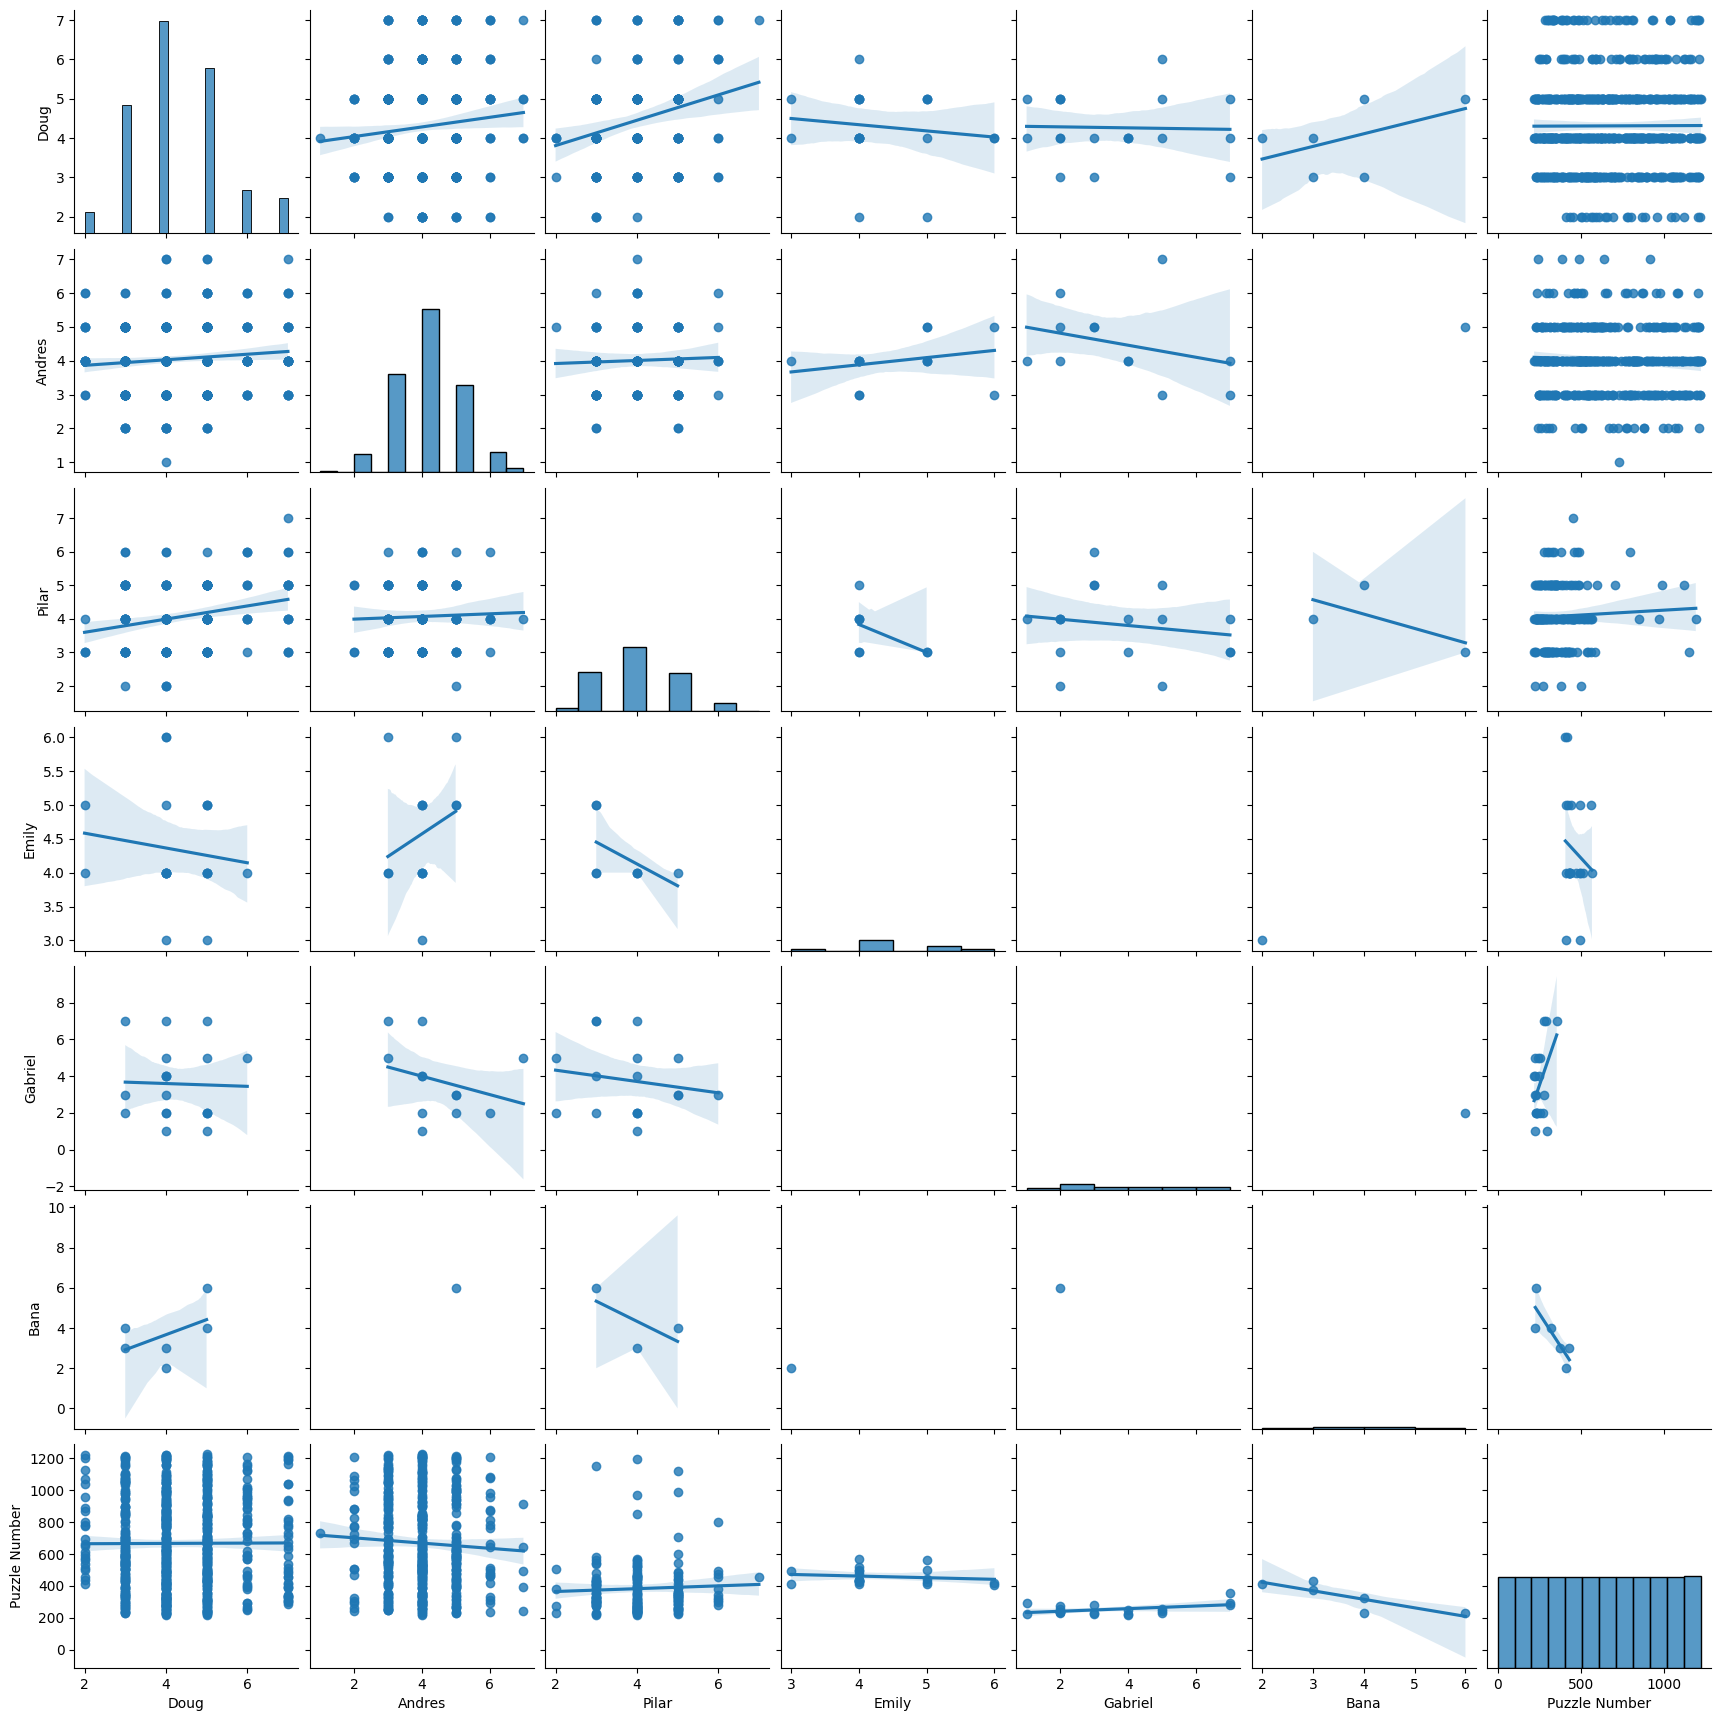

In [21]:
# Create dataframe
df = data.as_df()

# Set up figure
f, myax = plt.subplots(1, 2)
f.set_figwidth(10)

# Calculate Pearson's r-squared and t-test p-values
correlation_matrix = df.corr()

# Create lists of each comparison and pearson value
comparison = []
pearson = []
for col,person_1 in enumerate(correlation_matrix):
    values = correlation_matrix[person_1]
    for row in range(col+1,len(values)):
        person_2 = values.index[row]
        comparison.append(person_1+'-'+person_2)
        pearson.append(values.iloc[row])

# Create correlation dataframe from lists and sort 
corr_list = pd.DataFrame({'Comparison':comparison, 'Pearson Value': pearson})
corr_list = corr_list.sort_values(by=['Pearson Value'], axis=0, ascending=False, na_position='last')

# Plot correlation bar chart
corr_list.plot.bar(x='Comparison',
                   y = 'Pearson Value',
                   legend=False,
                   title='Correlation between scores',
                   ylabel='Pearson Value',
                   ax=myax[0]
                   )

# Plot heatmap of correlation
sns.heatmap(data.rolling(20).transpose(),
                 cmap='turbo',
                 vmin=0,
                 vmax=6,
                 ax=myax[1])
myax[1].set(title='Rolling Average Heatmap',
       xlabel='Puzzle number')

# Seaborn pairplot of each person's score compared to others
g = sns.pairplot(df,kind='reg')

### Which letter slots are easiest to guess? Slot 1?

### What are the most common letter patterns and their guess rates?

Cumulative probability of guessing word given number of correct letters guessed so far.